# Single Harmonic
This looks at how much information can be extracted about the seasonal cycle, restricting ourselves to a single harmonic.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier, gamma_linear_approx, swdn_from_temp_fourier
from isca_tools.thesis.hottest_date import get_var_extrema_date
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import optimize, ndimage
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [215]:
sigma_near_surf

0.9948700488727586

In [292]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc', 
            'flux_lhe', 'flux_t', 'drag_q', 'q_surf', 'rho', 'p_atm', 'ps', 'q_surf', 'ucomp', 'vcomp', 'w_atm']  
# Load dataset

# # DEFAULT experiment
# exp_dir = 'tau_sweep/aquaplanet/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}" for i in range(n_exp)]

# # Experiment with no-WISHE and no convection
# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}_no_conv" for i in range(n_exp)]

# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}" for i in range(n_exp)]

exp_dir = 'aquaplanet/latent_heat_temp_only/'
exp_name = ['evap=0_1']
n_exp = len(exp_name)

# Get low level sigma level
namelist = isca_tools.load_namelist(exp_dir+exp_name[0])
p_surface_approx = namelist['spectral_dynamics_nml']['reference_sea_level_press']/100
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk']) 
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

lat_range = slice(30, 60)               # only consider NH and outside deep tropics, and ignore high latitudes as need 2nd harmonic there
use_time_start = 360*2
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_use = ds_use.sel(time=slice(use_time_start, np.inf)).sel(lat=lat_range)
    ds_use = ds_use.sel(pfull=np.inf, method='nearest')      # only keep lowest level
    # Compute variables required for flux breakdown
    ds_use['emission_factor'] = (ds_use.lwdn_sfc/Stefan_Boltzmann)**0.25/ds_use.t_surf
    ds_use['temp_diseqb'] = ds_use.t_surf - ds_use.temp
    ds_use['rh'] = ds_use.sphum / sphum_sat(ds_use.temp, ds_use.ps*sigma_near_surf)
    ds_base += [ds_use.load()]      # only keep after spin up
mixed_layer_depth = [isca_tools.load_namelist(exp_dir+exp_name[i])['mixed_layer_nml']['depth'] for i in range(n_exp)]
try:
    w_atm_const = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['w_atm_const']
except KeyError:
    w_atm_const = np.nan
try: 
    rh_flux_q = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['rh_flux_q']
except KeyError:
    rh_flux_q = 0

  0%|          | 0/1 [00:00<?, ?it/s]

Removing height from var_keep


100%|██████████| 1/1 [00:04<00:00,  4.83s/it]


In [222]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [258]:
def get_annual_zonal_mean(ds):
    ds_av = annual_mean(ds).mean(dim='lon')
    ds_av = ds_av.assign_coords(time=(ds_av.time - ds_av.time.min()).astype(int))
    return ds_av

In [259]:
ds = get_annual_zonal_mean(ds_base[0])
p_surface = float(ds.pfull)*100
if isinstance(w_atm_const, (int, float)):
    if w_atm_const == 0 or w_atm_const == np.nan:
        w_atm_const = ds.w_atm.mean(dim='time')

In [225]:
# Make every thing dependent on surface temperature (NOT NEAR-SURFACE) as equation easier to solve
# Link to near-surface with T_{s-a} term in latent flux etc
n_lat = ds.lat.size
n_time = ds.time.size
t_surf = ds.t_surf.to_numpy().transpose()
t_surf_anom = t_surf - np.mean(t_surf, axis=1)[:, np.newaxis]
t_surf_spline_fit = [scipy.interpolate.CubicSpline(np.append(ds.time.to_numpy(), ds.time[-1]+1), 
                                                       np.append(t_surf[i], t_surf[i, 0]), bc_type='periodic') for i in range(n_lat)]
# t_surf_anom_spline_fit = scipy.interpolate.CubicSpline(np.append(ds.time.to_numpy(), ds.time[-1]+1), 
#                                                        np.append(t_surf_anom, t_surf_anom[0]), bc_type='periodic')

def linear_func(x_var_anom, a, b):
    if x_var_anom.min()>=0:
        raise ValueError('x_var_anom should be an anomaly relative to a mean value')
    return a + b*x_var_anom

def square_func(x_var_anom, a, b, c):
    # Subtract mean of squared anomaly so c does not influence value of a and b.
    x_anom_squared = x_var_anom**2
    return a + b*x_var_anom + c*(x_anom_squared - np.mean(x_anom_squared))

def quartic_func(x_var_anom, a, b, c, d, e):
    # Subtract mean of squared anomaly so c does not influence value of a and b.
    x_anom_cubed = (x_var_anom-np.mean(x_var_anom))**3
    x_anom_fourth_power = (x_var_anom-np.mean(x_var_anom))**4
    return square_func(x_var_anom, a, b, c) + d*(x_anom_cubed - np.mean(x_anom_cubed)) + \
        e*(x_anom_fourth_power-np.mean(x_anom_fourth_power))

def linear_func_shift(time, a, b, c, spline_anom):
    x_var_shift = spline_anom(time-c)
    return linear_func(x_var_shift, a, b)

func_approx = {'linear': linear_func, 'square': square_func, 'quartic': quartic_func, 'linear_shift': linear_func_shift}

## Obtaining Estimate of Amplitude and Phase of Actual Temperature Profile
Below, I smooth the temperature profile with a window of 20 days, and take the phase and amplitude of extrema from the resultant smoothed profile. These are indicated by the grey vertical lines, and differ slightly from the actual maxima and minima shown by the black solid lines.

I record the phase, as indicated by $\delta$, relative to the 1st harmonic of the insolation (shown by thick grey lines on left).

Below the example for a specific latitude, I plot the phase, $\delta$, and amplitude, $|T|$ for all latitudes. These are the values which we want to replicate, with a theoretical value.

In [226]:
sw_amp_coefs = {key: np.zeros((n_lat, 1+int(key.replace('_harmonic', '')))) for key in ['1_harmonic']}
sw_fourier_fit = {key: np.zeros((n_lat, n_time)) for key in ['1_harmonic']}
for i in range(n_lat):
    for key in sw_amp_coefs:
        sw_amp_coefs[key][i] = fourier.get_fourier_fit(ds.time, ds.swdn_sfc[:, i], n_time, int(key.replace('_harmonic', '')))[1]
        # Fit SW fourier with no phase
        sw_fourier_fit[key][i] = fourier.fourier_series(ds.time, n_time, sw_amp_coefs[key][i], np.zeros(int(key.replace('_harmonic', ''))))
# Record phase of maxima / minima relative to extrema times of 1st harmonic of SW radiation 
time_extrema_sw = {'min': int(ds.time[0]), 'max': int(ds.time[int(ds.time.size/2)])}
time_extrema_temp = {key: {'simulated': np.zeros(n_lat)} for key in ['min', 'max']}
amp_extrema_temp = {key: {'simulated': np.zeros(n_lat)} for key in ['min', 'max']}

smooth_ndays_temp_extrema = 20            # smoothing to temp annual mean to find date of hottest day
for i in range(n_lat):
    for key in time_extrema_temp:
        var_use, spline_use = get_var_extrema_date(ds.time, t_surf_anom[i], smooth_window=smooth_ndays_temp_extrema, 
                                                                     type=key, max_extrema=1)
        time_extrema_temp[key]['simulated'][i] = var_use[0]
        amp_extrema_temp[key]['simulated'][i] = np.abs(spline_use(time_extrema_temp[key]['simulated'][i]))

In [227]:
# General plotting info

plot_lat_ind = 4
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
ax_lims_time = [ds.time[0]-1, ds.time[-1]+1]
ax_lims_lat = [np.floor(ds.lat[0]), np.ceil(ds.lat[-1])]
color_approx = {'linear': default_colors[0], 'quartic': default_colors[3], 'quartic_1_harmonic': default_colors[3], '1_harmonic': 'k', 
                'lw': default_colors[3], 'lh': default_colors[1], 'sh': default_colors[2]}
color_extrema = {'max': default_colors[3], 'min': default_colors[0]}
linestyle_approx = {'linear': '-', 'quartic': ':', 'quartic_1_harmonic': '-', '1_harmonic': ':', 'lw': '-', 'lh': '-', 'sh': '-'}

# Define error func to use
error_func_dict = {'max': lambda x, x_approx: np.max(np.abs(x - x_approx), axis=1), 
                   'median': lambda x, x_approx: np.median(np.abs(x - x_approx), axis=1), 
                   'mean': lambda x, x_approx: np.mean(np.abs(x - x_approx), axis=1)}
error_func_use = 'median'
error_func = error_func_dict[error_func_use.lower()]

# Whether to show plots with smoothing of simulated values done or not. Theoretical curves always shown without smoothing
# Will also smooth simulated var but not approximated var before calculating error
# Fitting is always done with no smoothing performed first.
plot_smooth = True
if plot_smooth:
    smooth_func = lambda x, ax=-1: scipy.ndimage.convolve1d(x, np.ones(smooth_ndays_temp_extrema)/smooth_ndays_temp_extrema, mode='wrap', axis=ax)
else:
    smooth_func = lambda x, ax=0: x

In [228]:
fig_sw_temp_sl, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
ax[0].plot(ds.time, ds.swdn_sfc[:, plot_lat_ind], color='k', label='Simulated')

ax[1].plot(ds.time, smooth_func(t_surf_anom[plot_lat_ind]), color='k', label='Simulated')
for key in time_extrema_sw:
    ax[0].scatter(time_extrema_sw[key], ds.swdn_sfc.sel(time=time_extrema_sw[key])[plot_lat_ind],
                       color='grey', marker='|', s=1000, lw=2.5, alpha=0.5)
    ax[1].scatter(time_extrema_temp[key]['simulated'][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key]['simulated'][plot_lat_ind],
                       color='grey', marker='|', s=1000, lw=2.5, alpha=0.5)
    
ax[0].set_xlim(ax_lims_time)
ax[0].set_xticks(*month_ticks)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_ylim(-np.abs(ax[1].get_ylim()).max(), np.abs(ax[1].get_ylim()).max())
ax[0].set_ylabel('$SW^{\\downarrow}$ [Wm$^{-2}$]')
ax[1].set_ylabel('$T - \overline{T}$ [K]')
ax[0].legend()
ax[1].legend()
fig_sw_temp_sl.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$; "
             f"$\delta_{'{min}'}$={round(time_extrema_temp['min']['simulated'][plot_lat_ind]-time_extrema_sw['min'], 1)}; "
             f"$\delta_{'{max}'}$={round(time_extrema_temp['max']['simulated'][plot_lat_ind]-time_extrema_sw['max'], 1)} days", fontsize=8, y=0.93)
plt.close()

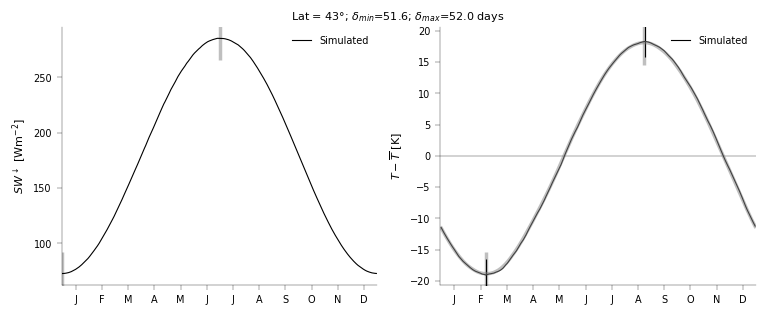

In [229]:
fig = copy.deepcopy(fig_sw_temp_sl)
ax = np.asarray(fig.axes)

ax[1].lines[0].set_ydata(t_surf_anom[plot_lat_ind])         # change y values of black line so actual not smoothed line
ax[1].plot(ds.time, scipy.ndimage.convolve1d(t_surf_anom[plot_lat_ind], np.ones(smooth_ndays_temp_extrema)/smooth_ndays_temp_extrema, 
                                             mode='wrap'), color='grey', lw=2.5, alpha=0.5)
ax[1].scatter(ds.time[t_surf_anom[plot_lat_ind].argmin()], t_surf_anom[plot_lat_ind].min(),
                   color='k', marker='|', s=500)
ax[1].scatter(ds.time[t_surf_anom[plot_lat_ind].argmax()], t_surf_anom[plot_lat_ind].max(),
                   color='k', marker='|', s=500)
ax[0].legend()
fig

In [230]:
fig_extrema, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True, sharey='row')
for i, key in enumerate(time_extrema_temp):
    ax[0, i].plot(ds.lat, time_extrema_temp[key]['simulated'] - time_extrema_sw[key], color='k', label='Simulated')
    ax[1, i].plot(ds.lat, amp_extrema_temp[key]['simulated'], color='k')
    ax[0, i].set_ylabel(f"$\delta_{'{'+key+'}'}$ [days]")
    ax[1, i].set_ylabel(f"$|T_{'{'+key+'}'}|$ [K]")
ax[0, 0].set_xlim(ax_lims_lat)
fig_extrema.supxlabel('Latitude [deg]', fontsize=8, y=0.05)
plt.close()

## Best Possible Estimate from just single harmonic

The surface energy budget is 
$$
C\frac{\partial T}{\partial t} = SW^{\downarrow} - (LW^{\uparrow} - LW^{\downarrow}) - LH^{\uparrow} - SH^{\uparrow}
= SW^{\downarrow} - \Gamma^{\downarrow}
$$

Later we seek the best possible solution with a single harmonic, by replacing $SW^{\downarrow}$ with the annual harmonic, but keeping the exact form of $\Gamma^{\downarrow}$. THis is done by fitting a spline to $SW^{\downarrow} - \Gamma^{\downarrow}$ before integrating.

The plot clearly indicates that at latitudes lower than $60\degree$, additional harmonics of $SW^{\downarrow}$ are required, but at lower latitudes one will suffice.

In [231]:
day_seconds = 86400
gamma = {'simulated':np.asarray(ds.lwup_sfc - ds.lwdn_sfc + ds.flux_lhe + ds.flux_t).transpose()}
heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth[0])
temp_approx = {key: np.zeros((n_lat, n_time)) for key in ['1_harmonic']}

for key in time_extrema_temp:
    for key2 in ['1_harmonic']:
        time_extrema_temp[key][key2] = np.zeros(n_lat)
        amp_extrema_temp[key][key2] = np.zeros(n_lat)
with (tqdm(total=n_lat*n_time, position=0, leave=True) as pbar):
    for i in range(n_lat):
        for key in ['1_harmonic']:
            var_use = (sw_fourier_fit['1_harmonic'][i] - gamma['simulated'][i])/heat_capacity
            var_use = np.append(var_use, var_use[0])
            spline_use = scipy.interpolate.CubicSpline(np.append(ds.time, ds.time[-1]+1)*day_seconds, var_use, bc_type='periodic')
            for j in range(n_time):
                temp_approx[key][i, j] += spline_use.integrate(0, ds.time[j]*day_seconds, extrapolate='periodic')
                pbar.update(1)
            for key2 in time_extrema_temp:
                var_use, spline_use = get_var_extrema_date(ds.time, temp_approx[key][i] - np.mean(temp_approx[key][i]),
                                                           smooth_window=smooth_ndays_temp_extrema, type=key2, max_extrema=1)
                time_extrema_temp[key2][key][i] = var_use[0]
                amp_extrema_temp[key2][key][i] = np.abs(spline_use(time_extrema_temp[key2][key][i]))
# Ensure have the same mean value as actual temperature
temp_approx['1_harmonic'] = temp_approx['1_harmonic']-temp_approx['1_harmonic'].mean(axis=1)[:, np.newaxis] + t_surf.mean(axis=1)[:, np.newaxis]

100%|██████████| 3960/3960 [00:01<00:00, 3224.61it/s]


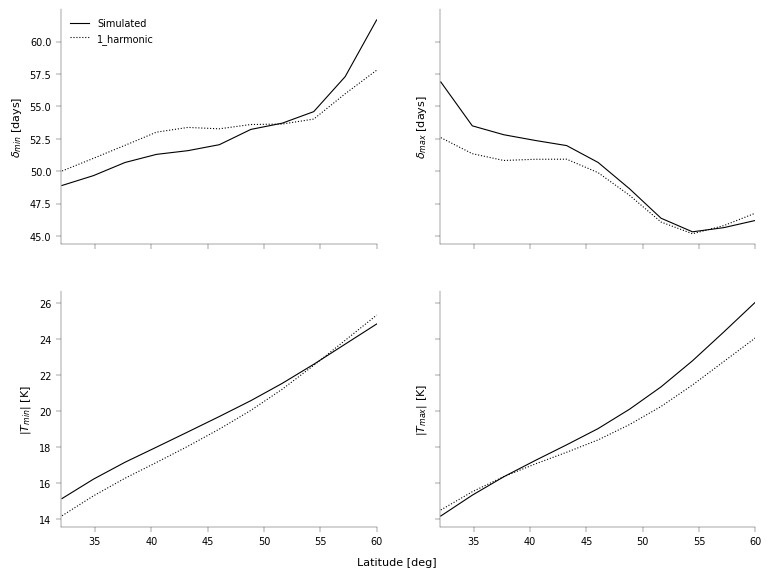

In [232]:
fig = copy.deepcopy(fig_extrema)
ax = np.asarray(fig.axes).reshape(2, 2)
for i, key in enumerate(time_extrema_temp):
    for key2 in ['1_harmonic']:
        ax[0, i].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_sw[key], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2], label=key2 if key2 != 'linear' else '2_harmonic')
        ax[1, i].plot(ds.lat, amp_extrema_temp[key][key2], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2])
ax[0, 0].legend()
fig

In [233]:
fig_error, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
key = '1_harmonic'
ax[0].axhline(0, color=color_approx[key], label=key, linestyle=linestyle_approx[key])
ax[1].plot(ds.lat, error_func(smooth_func(t_surf), temp_approx[key]), color=color_approx[key], 
           label=key, linestyle=linestyle_approx[key])
ax[1].legend()
ax[0].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|\Gamma^{\\uparrow} - \Gamma^{\\uparrow}_{approx}|$ [Wm$^{-2}$]')
ax[1].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|T - T_{approx}|$ [K]')
ax[0].set_xlim(ax_lims_lat)
fig_error.supxlabel('Latitude [deg]', fontsize=8)
plt.close()

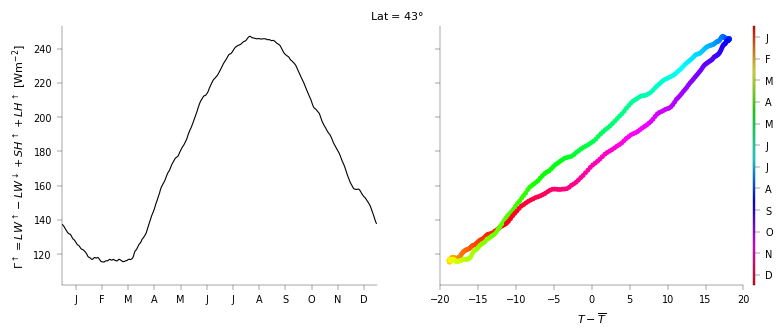

In [234]:
fig_sl_gamma, ax = plt.subplots(1,2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharey=True)
ax[0].plot(ds.time, smooth_func(gamma['simulated'][plot_lat_ind]), color='k', label='Simulated')
im = ax[1].scatter(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func(gamma['simulated'][plot_lat_ind]), c=ds.time, cmap='hsv')
# for key in ['linear', 'quartic']:
#     ax[0].plot(ds.time, gamma_approx[key][plot_lat_ind], 
#                color=color_approx[key], linestyle=linestyle_approx[key], label=key.lower())
#     ax[1].plot(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func(gamma_approx[key][plot_lat_ind]), 
#                color=color_approx[key], linestyle=linestyle_approx[key], label=key.lower())

cbar = fig.colorbar(im, ax=ax[1], aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
ax[0].set_ylabel('$\Gamma^{\\uparrow} = LW^{\\uparrow} - LW^{\\downarrow} + SH^{\\uparrow} + LH^{\\uparrow}$ [Wm$^{-2}$]')
ax[1].set_xlabel('$T - \overline{T}$')
ax[1].set_xlim(-np.ceil(np.abs(t_surf_anom[plot_lat_ind]).max()), np.ceil(np.abs(t_surf_anom[plot_lat_ind]).max()))
ax[1].set_ylim(np.floor(gamma['simulated'][plot_lat_ind].min()), np.ceil(gamma['simulated'][plot_lat_ind].max()))
# ax[0].legend()
ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
fig_sl_gamma.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=8, y=0.93);

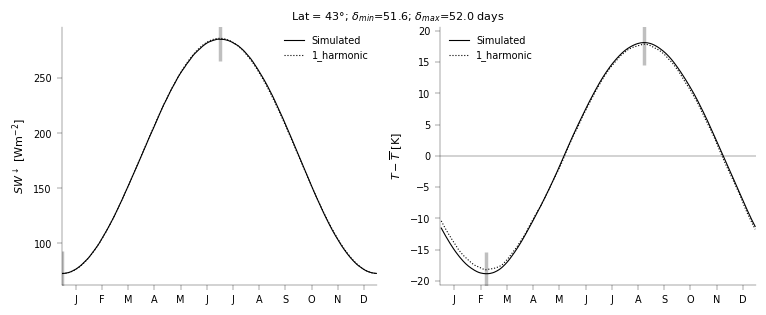

In [235]:
fig = copy.deepcopy(fig_sw_temp_sl)
ax = np.asarray(fig.axes)
key = '1_harmonic'
ax[0].plot(ds.time, sw_fourier_fit[key][plot_lat_ind], color='k', linestyle=':', label=key)
ax[1].plot(ds.time, temp_approx[key][plot_lat_ind]-temp_approx[key][plot_lat_ind].mean(), color=color_approx[key],
           linestyle=linestyle_approx[key], label=key)
ax[0].legend()
ax[1].legend()
fig

## Linear Surface Budget
The surface energy budget is $C\frac{\partial T}{\partial t} = SW^{\downarrow} - (LW^{\uparrow} - LW^{\downarrow}) - LH^{\uparrow} - SH^{\uparrow}$

If we can represent $\Gamma^{\uparrow}(t) = (LW^{\uparrow} - LW^{\downarrow}) + LH^{\uparrow} + SH^{\uparrow} \approx \lambda_0 + \lambda T'(t)$, and keep the single harmonic approximation of $SW^{\downarrow}$, then a Fourier solution for $T'(t)$ is possible:

$T'(t) = \frac{T_0}{2} + T_1\cos(2\pi ft - \phi)$

where $T' = T-\overline{T}$ is the temperature anomaly.

Below, we look at how accurate this approximation is.

In [236]:
def get_x_from_lambda(lambda_const, heat_capacity=heat_capacity, f=1/360, day_seconds=day_seconds):
    return 2*np.pi*f/day_seconds*heat_capacity/lambda_const


key = 'linear'
gamma_params0 = [150, 3]
gamma_params = {key: np.zeros((n_lat, 2))}
gamma[key] = np.zeros((n_lat, n_time))
for i in range(n_lat):
    gamma_params[key][i] = optimize.curve_fit(func_approx[key], t_surf_anom[i], gamma['simulated'][i], p0=gamma_params0)[0]
    gamma[key][i] = func_approx[key](t_surf_anom[i], *gamma_params[key][i])

temp_approx[key] = np.zeros((n_lat, n_time))
for i in range(n_lat):
    temp_approx[key][i] = get_temp_fourier(ds.time, sw_fourier_fit['1_harmonic'][i], heat_capacity, gamma_params[key][i], n_harmonics=1, return_anomaly=True)[0]
if np.abs(temp_approx[key].mean(axis=1)).max()>1e-12:
    raise ValueError('Fourier fit should have returned anomaly but mean is non-zero')
temp_approx[key] = temp_approx[key] + t_surf.mean(axis=1)[:, np.newaxis]        # make sure has same mean as actual temperature

# Use analytical solution for 1 harmonic so as to make value a float, more accurate
time_extrema_temp['min'][key] = np.arctan(get_x_from_lambda(gamma_params[key][:, 1], heat_capacity))/(2*np.pi)*360
time_extrema_temp['max'][key] = time_extrema_temp['min'][key]+360/2
amp_extrema_temp['min'][key] = np.abs(sw_amp_coefs['1_harmonic'][:, 1]/gamma_params[key][:, 1]/np.sqrt(
    1+get_x_from_lambda(gamma_params[key][:, 1], heat_capacity)**2))
amp_extrema_temp['max'][key] = amp_extrema_temp['min'][key]

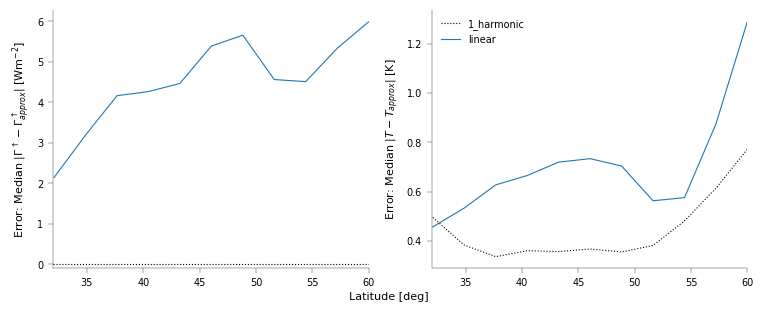

In [237]:
fig = copy.deepcopy(fig_error)
ax = np.asarray(fig.axes)
for key in ['linear']:
    ax[0].plot(ds.lat, error_func(smooth_func(gamma['simulated']), gamma[key]), color=color_approx[key],
               label=key, linestyle=linestyle_approx[key])
    ax[1].plot(ds.lat, error_func(smooth_func(t_surf), temp_approx[key]), color=color_approx[key],
               label=key, linestyle=linestyle_approx[key])
ax[1].legend()
ax[0].set_ylim(-0.1, ax[0].get_ylim()[1])
fig

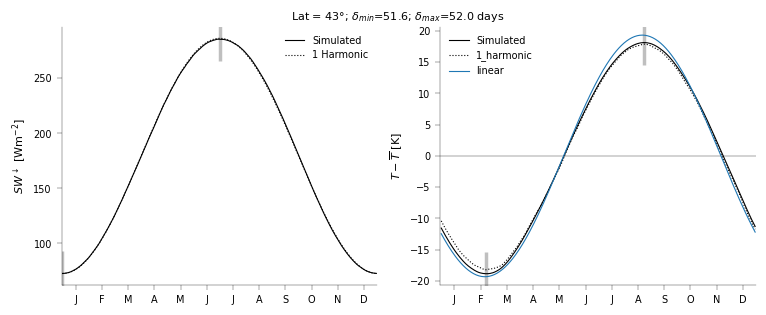

In [238]:
fig = copy.deepcopy(fig_sw_temp_sl)
ax = np.asarray(fig.axes)
ax[0].plot(ds.time, sw_fourier_fit['1_harmonic'][plot_lat_ind], color='k',
           linestyle=':', label='1 Harmonic')
for key2 in ['1_harmonic', 'linear']:
    ax[1].plot(ds.time, temp_approx[key2][plot_lat_ind]-temp_approx[key2][plot_lat_ind].mean(), color=color_approx[key2], 
               label=key2, linestyle=linestyle_approx[key2])

ax[0].legend()
ax[1].legend()
fig

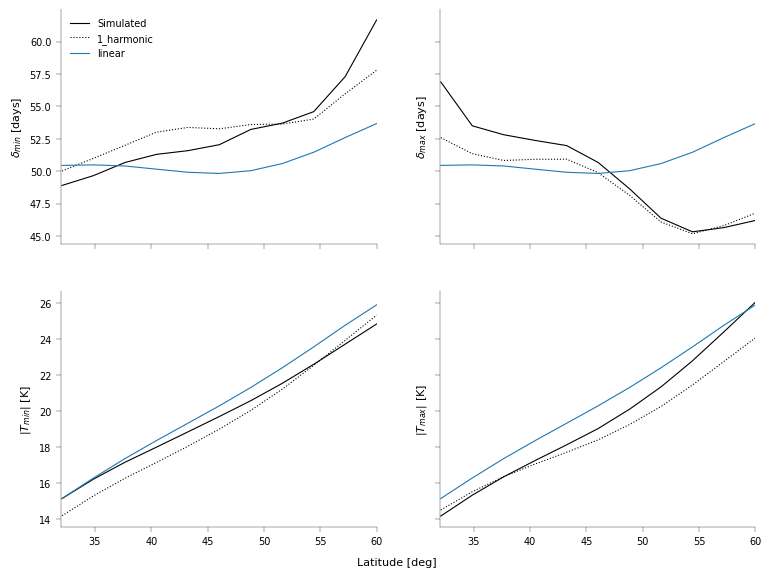

In [239]:
fig = copy.deepcopy(fig_extrema)
ax = np.asarray(fig.axes).reshape(2, 2)
for i, key in enumerate(time_extrema_temp):
    for key2 in ['1_harmonic', 'linear']:
        ax[0, i].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_sw[key], color=color_approx[key2], 
                      label=key2, linestyle=linestyle_approx[key2])
        ax[1, i].plot(ds.lat, amp_extrema_temp[key][key2], color=color_approx[key2], linestyle=linestyle_approx[key2])
    # ax[0, i].scatter(ds.lat, time_extrema_temp[key]['linear_taylor_calc'] - time_extrema_sw[key], color=color_approx['linear'], marker='+',
    #                  label='2_harmonic_taylor_calc')
    # ax[1, i].scatter(ds.lat, amp_extrema_temp[key]['linear_taylor_calc'], color=color_approx['linear'], marker='+')
ax[0, 0].legend()
fig

## Breakdown of $\Gamma^{\uparrow}$
Above we see that the linear surface budget approximation matches the amplitude of the extrema just as well as the exact $\Gamma$ solution with 1 harmonic, but it fails to capture the latitudinal trends in phase: minima occurs later in the year as latitude increases, while maxima occurs earlier.

This suggests that we can improve our approximation for $\Gamma$ at these lower latitudes by including $T^2$ or higher power terms etc, while neglecting further harmonics. We look into this now.

We first breakdown how good the linear approximation is for each term in $\Gamma$. We do this, by keeping each term in $\Gamma$ as the exact term, except for one which we set to be the linear approximation.

There is no obvious candidate here, although it is clear that the linear approximation of sensible heat pushes the coldest day later in the year, and pulls the hottest day earlier.

In [240]:
key = 'simulated'
gamma_comp_params = {key: {} for key in ['lw', 'lh', 'sh']}
gamma_comp = {key: {} for key in ['lw', 'lh', 'sh']}
gamma_comp['lw'][key] = (ds.lwup_sfc-ds.lwdn_sfc).transpose().to_numpy()
gamma_comp['lh'][key] = (ds.flux_lhe).transpose().to_numpy()
gamma_comp['sh'][key] = (ds.flux_t).transpose().to_numpy()
key = 'linear'
for key2 in gamma_comp:
    gamma_comp_params[key2][key] = np.zeros((n_lat, 2))
    gamma_comp[key2][key] = np.zeros((n_lat, n_time))
    gamma[key2] = np.zeros((n_lat, n_time))
    for i in range(n_lat):
        gamma_comp_params[key2][key][i] = optimize.curve_fit(func_approx[key], t_surf_anom[i], gamma_comp[key2]['simulated'][i])[0]
        gamma_comp[key2][key][i] = func_approx[key](t_surf_anom[i], *gamma_comp_params[key2][key][i])
        for key3 in gamma_comp:
            if key3 == key2:
                gamma[key2][i] += gamma_comp[key3][key][i]    # only linear approx for one component
            else:
                gamma[key2][i] += gamma_comp[key3]['simulated'][i]

In [241]:
with (tqdm(total=n_lat*n_time*len(gamma_comp), position=0, leave=True) as pbar):
    for key in gamma_comp:
        temp_approx[key] =  np.zeros((n_lat, n_time))
        for key2 in time_extrema_temp:
                time_extrema_temp[key2][key] = np.zeros(n_lat)
                amp_extrema_temp[key2][key] = np.zeros(n_lat)
        for i in range(n_lat):
            var_use = (sw_fourier_fit['1_harmonic'][i] - gamma[key][i]) / heat_capacity   
            var_use = np.append(var_use, var_use[0])
            spline_use = scipy.interpolate.CubicSpline(np.append(ds.time, ds.time[-1]+1)*day_seconds, var_use, bc_type='periodic')
            for j in range(n_time):
                temp_approx[key][i, j] += spline_use.integrate(0, ds.time[j]*day_seconds, extrapolate='periodic')
                pbar.update(1)
            for key2 in time_extrema_temp:
                var_use, spline_use = get_var_extrema_date(ds.time, temp_approx[key][i] - np.mean(temp_approx[key][i]),
                                                           smooth_window=smooth_ndays_temp_extrema, type=key2, max_extrema=1)
                time_extrema_temp[key2][key][i] = var_use[0]
                amp_extrema_temp[key2][key][i] = np.abs(spline_use(time_extrema_temp[key2][key][i]))
            # Ensure have the same mean value as actual temperature
            temp_approx[key] = temp_approx[key]-temp_approx[key].mean(axis=1)[:, np.newaxis] + t_surf.mean(axis=1)[:, np.newaxis]

100%|██████████| 11880/11880 [00:03<00:00, 3283.50it/s]


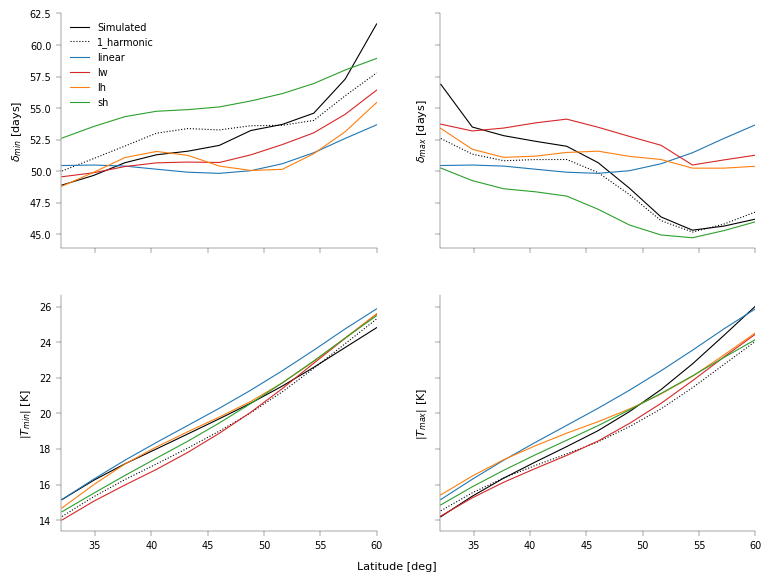

In [242]:
fig = copy.deepcopy(fig_extrema)
ax = np.asarray(fig.axes).reshape(2, 2)
for i, key in enumerate(time_extrema_temp):
    for key2 in ['1_harmonic', 'linear', 'lw', 'lh', 'sh']:
        ax[0, i].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_sw[key], color=color_approx[key2], 
                      label=key2, linestyle=linestyle_approx[key2])
        ax[1, i].plot(ds.lat, amp_extrema_temp[key][key2], color=color_approx[key2], linestyle=linestyle_approx[key2])
ax[0, 0].legend()
fig

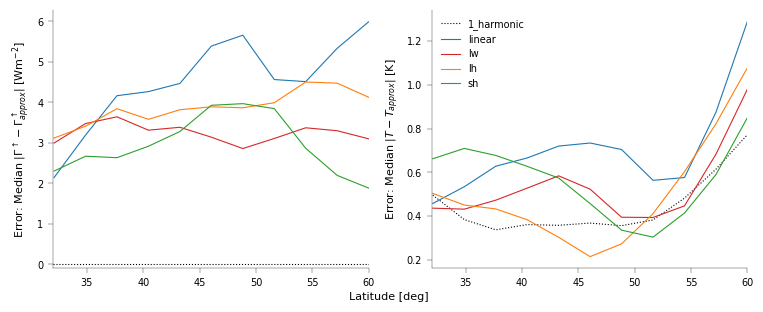

In [243]:
fig = copy.deepcopy(fig_error)
ax = np.asarray(fig.axes)
for key in ['linear', 'lw', 'lh', 'sh']:
    ax[0].plot(ds.lat, error_func(smooth_func(gamma['simulated']), gamma[key]), color=color_approx[key],
               label=key, linestyle=linestyle_approx[key])
    ax[1].plot(ds.lat, error_func(smooth_func(t_surf), temp_approx[key]), color=color_approx[key],
               label=key, linestyle=linestyle_approx[key])
ax[1].legend()
ax[0].set_ylim(-0.1, ax[0].get_ylim()[1])
fig

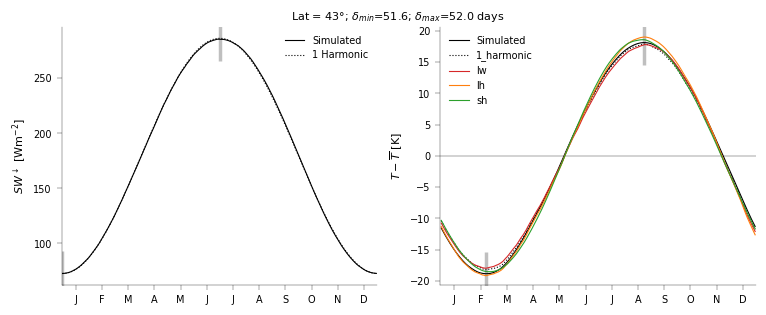

In [244]:
fig = copy.deepcopy(fig_sw_temp_sl)
ax = np.asarray(fig.axes)
ax[0].plot(ds.time, sw_fourier_fit['1_harmonic'][plot_lat_ind], color='k',
           linestyle=':', label='1 Harmonic')
for key2 in ['1_harmonic', 'lw', 'lh', 'sh']:
    ax[1].plot(ds.time, temp_approx[key2][plot_lat_ind]-temp_approx[key2][plot_lat_ind].mean(), color=color_approx[key2], 
               label=key2, linestyle=linestyle_approx[key2])

ax[0].legend()
ax[1].legend()
fig

## Sensible Heat
The most obvious result from the above analysis is that the linear approximation of sensible heat changes the phasing in quite a systematic way. We now investigate why that is the case.

The equation for sensible heat is: $SH = c_p C_t\rho |v|\bigg(T_s - T_a\big(\frac{p_s}{p_a}\big)^{\kappa}\bigg)$

So given that $\rho = \sigma_a p_a/RT_a$ where $T_a = T_s - T_{diseqb}$ and $p_a = \sigma_ap_s$, sensible heat is only a function of 5 variables:
 
* Surface temperature, $T_s$
* Disequilibrium temperature, $T_{diseqb}$
* Drag coefficient $C_t$
* Wind speed, $|v|$
* Surface pressure $p_s$.

Below we investigate the relative contribution of each of these factors.

In [281]:
def get_sensible_heat(temp_surf, temp_diseqb, p_surf, wind_speed, drag_coef, sigma=sigma_near_surf):
    temp_a = temp_surf - temp_diseqb
    p_a = p_surf*sigma
    rho = get_density(temp_a, p_a)
    return c_p * drag_coef * rho * wind_speed * (temp_surf - temp_a * (p_surf/p_a)**kappa)

In [319]:
sh_manual = {'all_cont': get_annual_zonal_mean(get_sensible_heat(ds_base[0].t_surf, ds_base[0].temp_diseqb, 
                                                             ds_base[0].ps, ds_base[0].w_atm, 
                                                             ds_base[0].drag_q)), 
             'all_cont_av_first': get_sensible_heat(ds.t_surf, ds.temp_diseqb, 
                                                             ds.ps, ds.w_atm, 
                                                             ds.drag_q),
             'mean': get_sensible_heat(ds_base[0].t_surf.mean(dim='time'), ds_base[0].temp_diseqb.mean(dim='time'), 
                                                             ds_base[0].ps.mean(dim='time'), ds_base[0].w_atm.mean(dim='time'), 
                                                             ds_base[0].drag_q.mean(dim='time')).mean(dim='lon'),
             't_surf_cont': get_annual_zonal_mean(get_sensible_heat(ds_base[0].t_surf, ds_base[0].temp_diseqb.mean(dim='time'), 
                                             ds_base[0].ps.mean(dim='time'), ds_base[0].w_atm.mean(dim='time'), 
                                             ds_base[0].drag_q.mean(dim='time'))), 
             'temp_diseqb_cont': get_annual_zonal_mean(get_sensible_heat(ds_base[0].t_surf.mean(dim='time'), ds_base[0].temp_diseqb, 
                                                   ds_base[0].ps.mean(dim='time'), ds_base[0].w_atm.mean(dim='time'), 
                                                   ds_base[0].drag_q.mean(dim='time'))),
             'pressure_cont': get_annual_zonal_mean(get_sensible_heat(ds_base[0].t_surf.mean(dim='time'), ds_base[0].temp_diseqb.mean(dim='time'), 
                                                   ds_base[0].ps, ds_base[0].w_atm.mean(dim='time'), 
                                                   ds_base[0].drag_q.mean(dim='time'))),
             'wind_cont': get_annual_zonal_mean(get_sensible_heat(ds_base[0].t_surf.mean(dim='time'), ds_base[0].temp_diseqb.mean(dim='time'), 
                                                   ds_base[0].ps.mean(dim='time'), ds_base[0].w_atm, 
                                                   ds_base[0].drag_q.mean(dim='time'))),
             'drag_cont': get_annual_zonal_mean(get_sensible_heat(ds_base[0].t_surf.mean(dim='time'), ds_base[0].temp_diseqb.mean(dim='time'), 
                                                   ds_base[0].ps.mean(dim='time'), ds_base[0].w_atm.mean(dim='time'), 
                                                   ds_base[0].drag_q))         
             }
for key in sh_manual:
    if ('cont' in key) and ('all' not in key):
        sh_manual[key] -= sh_manual['mean']

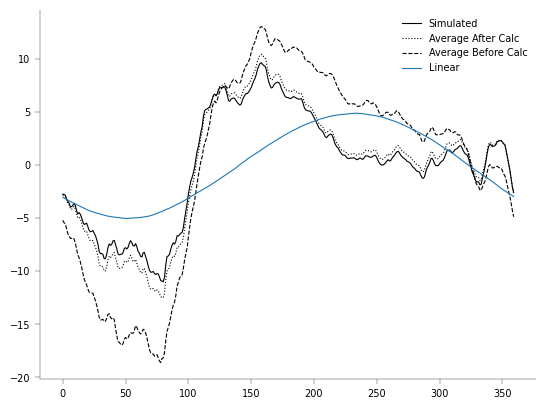

In [327]:
fig, ax = plt.subplots(1,1, figsize=(2*width['one_col'], 2*width['one_col']/ar))
ax.plot(ds.time, smooth_func(ds.flux_t.isel(lat=plot_lat_ind)-ds.flux_t.isel(lat=plot_lat_ind).mean()), color='k', label='Simulated')
ax.plot(ds.time, smooth_func(sh_manual['all_cont'].isel(lat=plot_lat_ind)-sh_manual['all_cont'].isel(lat=plot_lat_ind).mean()), color='k',
        linestyle=':', label='Average After Calc')
ax.plot(ds.time, smooth_func(sh_manual['all_cont_av_first'].isel(lat=plot_lat_ind)-
                             sh_manual['all_cont_av_first'].isel(lat=plot_lat_ind).mean()), color='k', linestyle='--', 
        label='Average Before Calc')
ax.plot(ds.time, gamma_comp['sh']['linear'][plot_lat_ind]-gamma_comp['sh']['linear'][plot_lat_ind].mean(), label='Linear')
ax.legend()

# ax.plot(ds.time, smooth_func((sh_manual['t_surf_cont']+sh_manual['temp_diseqb_cont']+sh_manual['wind_cont']+
#                               sh_manual['drag_cont']+sh_manual['pressure_cont']).isel(lat=plot_lat_ind)))
# ax.plot(ds.time, smooth_func(sh_manual['temp_diseqb_cont'].isel(lat=plot_lat_ind)))
# ax.plot(ds.time, smooth_func(sh_manual['t_surf_cont'].isel(lat=plot_lat_ind)))
# ax.plot(ds.time, gamma_comp['sh']['linear'][plot_lat_ind]-gamma_comp['sh']['linear'][plot_lat_ind].mean())
# ax.plot(ds.time, smooth_func(sh_manual['drag_cont'].isel(lat=plot_lat_ind)))
# ax.plot(ds.time, smooth_func(sh_manual['pressure_cont'].isel(lat=plot_lat_ind)))

In [268]:
get_sensible_heat(ds_base[0].t_surf.mean(dim='time'), ds_base[0].temp_diseqb.mean(dim='time'), 
                                                             ds_base[0].ps.mean(dim='time'), ds_base[0].w_atm.mean(dim='time'), 
                                                             ds_base[0].drag_q.mean(dim='time'))

<xarray.DataArray (lat: 11, lon: 128)> Size: 6kB
array([[82.14123 , 82.263664, 83.00055 , ..., 81.75192 , 81.0875  ,
        82.09764 ],
       [84.671005, 84.225266, 84.804565, ..., 85.46835 , 84.413666,
        85.03549 ],
       [85.26949 , 84.66695 , 84.498985, ..., 85.421455, 85.37666 ,
        85.140755],
       ...,
       [53.635952, 53.572247, 53.90706 , ..., 53.916065, 54.14334 ,
        53.934116],
       [48.006752, 48.02872 , 47.96096 , ..., 47.676285, 47.822147,
        47.73008 ],
       [42.15931 , 42.258694, 42.229794, ..., 41.89655 , 41.93261 ,
        41.96446 ]], dtype=float32)
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 88B 32.09 34.88 37.67 40.46 ... 54.42 57.21 60.0
    pfull    float64 8B 994.9

In [267]:
ds_base[0].t_surf

<xarray.DataArray 't_surf' (time: 1800, lat: 11, lon: 128)> Size: 10MB
array([[[293.61328, 293.80505, 294.3901 , ..., 294.90475, 294.444  ,
         293.90384],
        [291.18622, 290.80505, 290.91537, ..., 292.75235, 292.57703,
         291.92123],
        [288.33405, 287.845  , 287.58545, ..., 288.6429 , 288.88   ,
         288.74423],
        ...,
        [265.3177 , 265.4165 , 265.54926, ..., 265.12634, 265.14755,
         265.22293],
        [263.0466 , 262.98117, 262.89108, ..., 262.64032, 262.85822,
         263.0088 ],
        [260.4392 , 260.20114, 259.98203, ..., 260.47028, 260.63327,
         260.60846]],

       [[293.24994, 293.41064, 293.97818, ..., 294.57974, 294.09067,
         293.55066],
        [290.66678, 290.28683, 290.3974 , ..., 292.32373, 292.07553,
         291.3978 ],
        [287.77966, 287.27396, 287.02716, ..., 288.34076, 288.47598,
         288.25   ],
...
        [271.76984, 271.4059 , 270.90976, ..., 272.83206, 272.58414,
         272.1444 ],
        [269.56894, 269.1467 , 268.56226, ..., 270.87802, 270.3849 ,
         269.9515 ],
        [267.4919 , 266.83142, 266.0205 , ..., 268.93982, 268.50406,
         268.02737]],

       [[291.35065, 291.6084 , 291.88968, ..., 291.11496, 290.94376,
         291.02615],
        [288.79453, 288.75702, 288.901  , ..., 289.07114, 288.89557,
         288.80896],
        [286.68585, 286.51483, 286.3153 , ..., 287.02243, 287.08984,
         286.94785],
        ...,
        [271.47766, 271.07355, 270.53894, ..., 272.5061 , 272.2903 ,
         271.8716 ],
        [269.2956 , 268.83688, 268.21243, ..., 270.645  , 270.16513,
         269.70923],
        [267.23657, 266.56268, 265.73126, ..., 268.6776 , 268.2519 ,
         267.77798]]], dtype=float32)
Coordinates:
  * time     (time) float64 14kB 720.5 721.5 722.5 ... 2.518e+03 2.52e+03
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 88B 32.09 34.88 37.67 40.46 ... 54.42 57.21 60.0
    pfull    float64 8B 994.9
Attributes:
    long_name:      surface temperature
    units:          K
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [ ]:
ds_lat_no_av = ds_base[0].sel(lat=lat_plot, method='nearest').sel(pfull=p_surface_approx, method='nearest').load()

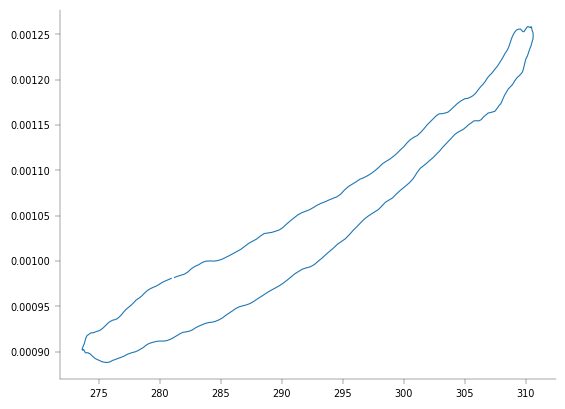

In [204]:
plt.plot(smooth_func(ds.t_surf.isel(lat=plot_lat_ind)), smooth_func(ds.w.isel(lat=plot_lat_ind)))

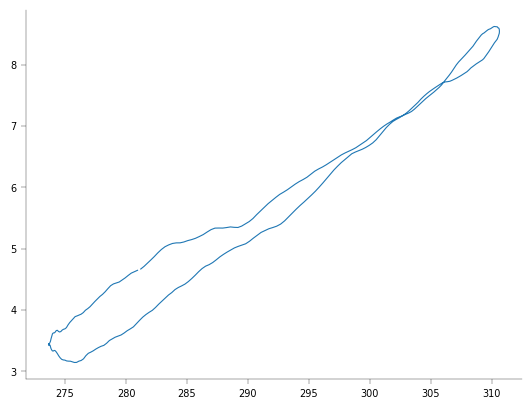

In [201]:
plt.plot(smooth_func(ds.temp_diseqb.isel(lat=plot_lat_ind)))

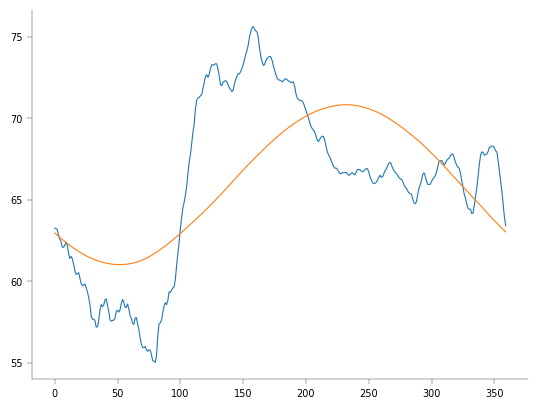

In [197]:
plt.plot(smooth_func(gamma_comp['sh']['simulated'][plot_lat_ind]))
plt.plot(smooth_func(gamma_comp['sh']['linear'][plot_lat_ind]))

### Longwave
Looks at emissivity stuff

In [56]:
emiss_factor = ((ds.lwdn_sfc/Stefan_Boltzmann)**0.25/ds.t_surf).transpose().to_numpy()
emiss_factor_params = {'linear': np.zeros((n_lat, 2)), 'quartic': np.zeros((n_lat, 5))}
emiss_factor_approx = {key: np.zeros((n_lat, n_time)) for key in ['linear', 'quartic']}
for i in range(n_lat):
    emiss_factor_params['linear'][i] = optimize.curve_fit(linear_func, t_surf_anom[i], emiss_factor[i])[0]
    emiss_factor_params['quartic'][i] = optimize.curve_fit(quartic_func, t_surf_anom[i], emiss_factor[i])[0]
    emiss_factor_approx['linear'][i] = linear_func(t_surf_anom[i], *emiss_factor_params['linear'][i])
    emiss_factor_approx['quartic'][i] = quartic_func(t_surf_anom[i], *emiss_factor_params['quartic'][i])

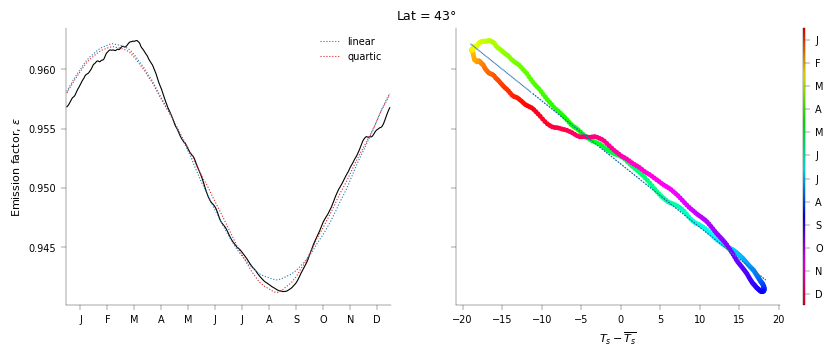

In [57]:
fig, ax = plt.subplots(1,2, figsize=(2*1.5*width['one_col'], 1.5*width['one_col']/ar), sharey=True)
ax[0].plot(ds.time, smooth_func(emiss_factor[plot_lat_ind]), color='k')
for key in ['linear', 'quartic']:
    ax[0].plot(ds.time, emiss_factor_approx[key][plot_lat_ind], color=color_approx[key], label=key, linestyle=':')
# ax[0].plot(ds.time, emiss_factor_approx['quartic'][plot_lat_ind], color=default_colors[0], linestyle=linestyles_approx['linear_shift'], 
#            label=f"linear shift; $\Lambda = {round(emiss_factor_params['linear_shift'][-1], 1)}$ days")
im = ax[1].scatter(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func(emiss_factor[plot_lat_ind]), c=ds.time, cmap='hsv')
ax[1].plot(t_surf_anom[plot_lat_ind], emiss_factor_approx['linear'][plot_lat_ind], color=color_approx['linear'], linestyle=':')
# ax[1].plot(t_surf_anom, emiss_factor_approx['linear_shift'][plot_lat_ind], color='k', linestyle=linestyles_approx['linear_shift'])
ax[0].set_xlim(-1, 360)
ax[0].legend()
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Emission factor, $\epsilon$')
ax[1].set_xlabel('$T_s - \overline{T_s}$')
fig.suptitle(f'Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$', fontsize=9, y=0.93);

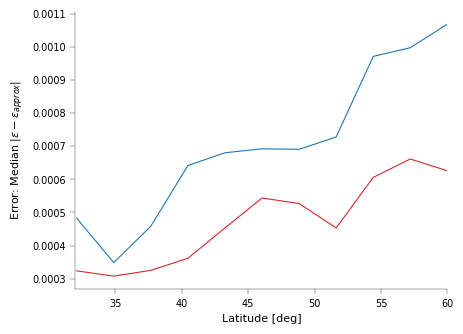

In [58]:
fig, ax = plt.subplots(1,1, figsize=(1.5*width['one_col'], 1.5*width['one_col']/ar), sharey=True)
for key in emiss_factor_approx:
    ax.plot(ds.lat, error_func(smooth_func(emiss_factor), emiss_factor_approx[key]), color=color_approx[key], label=key)
ax.set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|\epsilon - \epsilon_{approx}|$')
ax.set_xlim(ax_lims_lat)
ax.set_xlabel('Latitude [deg]');